In [1]:
# Block 1: Setup and Initialization
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
import ufl
from dolfinx import mesh, fem
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc

# Domain and Function Space Setup
nx, ny = 5, 5
domain = mesh.create_unit_square(MPI.COMM_WORLD, nx, ny, mesh.CellType.triangle)
V = fem.functionspace(domain, ("Lagrange", 1))

# Exact Solution Class
class exact_solution():
    def __init__(self, alpha, beta, t):
        self.alpha = alpha
        self.beta = beta
        self.t = t

    def __call__(self, x):
        return -np.sin(np.pi*self.alpha*x[0])*np.sin(np.pi*self.beta*x[1])* np.exp(-(self.alpha**2 + self.beta**2)*np.pi**2* self.t)

alpha, beta = 10, 1
t0, t1 = 0, 20
u_exact = exact_solution(alpha, beta, t0)
u_D = fem.Function(V)
u_D.interpolate(u_exact)

# Dirichlet Boundary Condition
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets))

# Initial Condition
u_n = fem.Function(V)
u_n.interpolate(u_exact)
f = fem.Constant(domain, 0.0)

# Variational Form
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
dt = 0.05 / 20  # Time step size
F = u * v * ufl.dx + dt * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx - (u_n + dt * f) * v * ufl.dx
a = fem.form(ufl.lhs(F))
L = fem.form(ufl.rhs(F))

# Assembling Matrix
A = assemble_matrix(a, bcs=[bc])
A.assemble()
b = create_vector(L)


In [2]:
# Block 2: Adaptive Integrator and Predictor Setup
from adaptive.integrator import SimpsonsRulePDE
from adaptive.predictor import PredictorQPDE
from adaptive.build_models import build_value_model
from adaptive.reward_functions import RewardLog10
from sklearn.preprocessing import StandardScaler
from adaptive.experience import Experience

integrator = SimpsonsRulePDE()  
step_sizes = np.linspace(0.2, 0.5, 11)
dim_state = 4
dim_action = len(step_sizes)
memory = 0
tol = 0.0005

reward_fun = RewardLog10(error_tol=tol, step_size_range=(step_sizes[0], step_sizes[-1]), reward_range=(0.1, 2))
scaler = StandardScaler()
scaler.scale_ = np.ones(dim_state)
scaler.mean_ = np.zeros(dim_state)
model = build_value_model(dim_state=dim_state, dim_action=dim_action, lr=0.001)
predictor = PredictorQPDE(step_sizes=step_sizes, model=model, scaler=scaler)
experience = Experience(batch_size=32)
print("Shape of scaler mean_:", scaler.mean_.shape)
print("Shape of scaler scale_:", scaler.scale_.shape)


2024-09-02 17:47:42.899846: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 17:47:42.904456: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 17:47:42.974991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 17:47:44.133274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Shape of scaler mean_: (4,)
Shape of scaler scale_: (4,)


In [3]:
# Block 3: Environment Setup
from adaptive.environments import PDEEnv
from functions import Sinusoid, HeatEquation

initial_state = np.zeros(dim_state)  # Example placeholder
step_size_range = (step_sizes[0], step_sizes[-1])  # Define step size range
max_dist=(t1-t0)

env = PDEEnv(fun=HeatEquation(),max_iterations=10000, initial_step_size=step_sizes[0],
              step_size_range=step_size_range, reward_fun=reward_fun, error_tol=tol,
              initial_state=initial_state, t0=t0,max_dist=max_dist, nodes_per_integ=4,memory=memory)



In [4]:
# Block 3: Solver Setup
uh = fem.Function(V)
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


In [5]:
# Block 4: Choose Action Function
def choose_action(actions, eps, dim_action):
    favored = np.argmax(actions)
    if np.random.sample() < 0.5 * eps:
        return min(favored + 1, dim_action - 1)
    elif np.random.sample() < eps:
        return max(favored - 1, 0)
    else:
        return favored

In [6]:
# Block 4: Time-Stepping Loop with Backward Euler Integration
import warnings
warnings.filterwarnings('ignore')

gamma = 0  # discount factor for future rewards

for episode in range(5):
    state = env.reset(integrator)
    done = False
    eps = 0.66
    print(f'Episode: {episode}')

    while not done:
        actions = predictor.get_actions(state)
        action = choose_action(actions, eps, dim_action)
        step_size = predictor.action_to_stepsize(action)

        # Update Dirichlet Boundary Condition
        u_exact.t += step_size
        u_D.interpolate(u_exact)

        # Update RHS
        with b.localForm() as loc_b:
            loc_b.set(0)
        assemble_vector(b, L)
        apply_lifting(b, [a], [[bc]])
        b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b, [bc])

        # Solve Linear Problem
        solver.solve(b, uh.vector)
        uh.x.scatter_forward()

        # Update State and Reward using simpson
        next_state, reward, done, _ = env.iterate(step_size, integrator)
        action_next_state = predictor.get_actions(next_state)
        target = reward + gamma * np.max(action_next_state)
        target_actions = actions.squeeze()
        target_actions[action] = target
        experience.append(state=state[0], target=target_actions)

        if experience.is_full() or done:
            states, targets = experience.get_samples()
            print("states",states.shape)
            print("targets", targets.shape)
            loss_predictor = predictor.train_on_batch(states, targets)
            experience.reset()

        state = next_state.copy()
        u_n.x.array[:] = uh.x.array


t 0
node [0. 0. 0. 0.]
h 0.2
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
Episode: 0
step_size: 0.2
f_evals shape: (3, 4)
f_evals content: [array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]
t 0
node [0.2 0.2 0.2 0.2]
h 0.2
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c45984f7b50>]
step_size: 0.2
f_evals shape: (3, 4)
f_evals content: [array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2])]
step_size: 0.2
f_evals shape: (3, 4)
f_evals content: [array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2])]
t 0.2
node [0.24 0.24 0.24 0.24]
h 0.23
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c45979aee90>]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [

memory states [<adaptive.integrator.StatePDE object at 0x7c462eb0f010>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.30252844, 0.30252844, 0.30252844, 0.30252844]), array([0.30252844, 0.30252844, 0.30252844, 0.30252844]), array([0.30252844, 0.30252844, 0.30252844, 0.30252844])]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.30252844, 0.30252844, 0.30252844, 0.30252844]), array([0.30252844, 0.30252844, 0.30252844, 0.30252844]), array([0.30252844, 0.30252844, 0.30252844, 0.30252844])]
t 4.7
node [0.49496081 0.49496081 0.49496081 0.49496081]
h 0.2
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4598aa8090>]
step_size: 0.2
f_evals shape: (3, 4)
f_evals content: [array([0.49496081, 0.49496081, 0.49496081, 0.49496081]), array([0.49496081, 0.49496081, 0.49496081, 0.49496081]), array([0.49496081, 0.49496081, 0.49496081, 0.49496081])]
step_size: 0.2
f_evals

memory states [<adaptive.integrator.StatePDE object at 0x7c459799bfd0>]
step_size: 0.41000000000000003
f_evals shape: (3, 4)
f_evals content: [array([0.29877402, 0.29877402, 0.29877402, 0.29877402]), array([0.29877402, 0.29877402, 0.29877402, 0.29877402]), array([0.29877402, 0.29877402, 0.29877402, 0.29877402])]
step_size: 0.41000000000000003
f_evals shape: (3, 4)
f_evals content: [array([0.29877402, 0.29877402, 0.29877402, 0.29877402]), array([0.29877402, 0.29877402, 0.29877402, 0.29877402]), array([0.29877402, 0.29877402, 0.29877402, 0.29877402])]
t 9.000000000000002
node [0.53249735 0.53249735 0.53249735 0.53249735]
h 0.23
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4596f16710>]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [array([0.53249735, 0.53249735, 0.53249735, 0.53249735]), array([0.53249735, 0.53249735, 0.53249735, 0.53249735]), array([0.53249735, 0.53249735, 0.

step_size: 0.44
f_evals shape: (3, 4)
f_evals content: [array([0.35247439, 0.35247439, 0.35247439, 0.35247439]), array([0.35247439, 0.35247439, 0.35247439, 0.35247439]), array([0.35247439, 0.35247439, 0.35247439, 0.35247439])]
t 9.670000000000002
node [0.59508873 0.59508873 0.59508873 0.59508873]
h 0.44
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4595baef50>]
step_size: 0.44
f_evals shape: (3, 4)
f_evals content: [array([0.59508873, 0.59508873, 0.59508873, 0.59508873]), array([0.59508873, 0.59508873, 0.59508873, 0.59508873]), array([0.59508873, 0.59508873, 0.59508873, 0.59508873])]
step_size: 0.44
f_evals shape: (3, 4)
f_evals content: [array([0.59508873, 0.59508873, 0.59508873, 0.59508873]), array([0.59508873, 0.59508873, 0.59508873, 0.59508873]), array([0.59508873, 0.59508873, 0.59508873, 0.59508873])]
t 10.110000000000001
node [0.70183904 0.70183904 0.70183904 0.70183904]
h 0.38

memory states [<adaptive.integrator.StatePDE object at 0x7c4596f1c350>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.73880911, 0.73880911, 0.73880911, 0.73880911]), array([0.73880911, 0.73880911, 0.73880911, 0.73880911]), array([0.73880911, 0.73880911, 0.73880911, 0.73880911])]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.73880911, 0.73880911, 0.73880911, 0.73880911]), array([0.73880911, 0.73880911, 0.73880911, 0.73880911]), array([0.73880911, 0.73880911, 0.73880911, 0.73880911])]
t 15.440000000000003
node [0.66074746 0.66074746 0.66074746 0.66074746]
h 0.41000000000000003
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4596fd6f50>]
step_size: 0.41000000000000003
f_evals shape: (3, 4)
f_evals content: [array([0.66074746, 0.66074746, 0.66074746, 0.66074746]), array([0.66074746, 0.66074746, 0.66074746, 0.66074746]), array([0.66074746, 0.66074746, 0

memory states [<adaptive.integrator.StatePDE object at 0x7c4596f2a9d0>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.66834359, 0.66834359, 0.66834359, 0.66834359]), array([0.66834359, 0.66834359, 0.66834359, 0.66834359]), array([0.66834359, 0.66834359, 0.66834359, 0.66834359])]
states (26,)
targets (26, 11)
step_size: 0.44
f_evals shape: (3, 4)
f_evals content: [array([0.35247439, 0.35247439, 0.35247439, 0.35247439]), array([0.35247439, 0.35247439, 0.35247439, 0.35247439]), array([0.35247439, 0.35247439, 0.35247439, 0.35247439])]
step_size: 0.44
f_evals shape: (3, 4)
f_evals content: [array([0.59508873, 0.59508873, 0.59508873, 0.59508873]), array([0.59508873, 0.59508873, 0.59508873, 0.59508873]), array([0.59508873, 0.59508873, 0.59508873, 0.59508873])]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.70183904, 0.70183904, 0.70183904, 0.70183904]), array([0.70183904, 0.70183904, 0.70183904, 0.70183904]), array([0.70183904, 0.70183904, 0.70183904, 0.70

memory states [<adaptive.integrator.StatePDE object at 0x7c45951e5090>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.276096, 0.276096, 0.276096, 0.276096]), array([0.276096, 0.276096, 0.276096, 0.276096]), array([0.276096, 0.276096, 0.276096, 0.276096])]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.276096, 0.276096, 0.276096, 0.276096]), array([0.276096, 0.276096, 0.276096, 0.276096]), array([0.276096, 0.276096, 0.276096, 0.276096])]
t 1.13
node [0.48491648 0.48491648 0.48491648 0.48491648]
h 0.23
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c459653be50>]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [array([0.48491648, 0.48491648, 0.48491648, 0.48491648]), array([0.48491648, 0.48491648, 0.48491648, 0.48491648]), array([0.48491648, 0.48491648, 0.48491648, 0.48491648])]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [array([0.48

memory states [<adaptive.integrator.StatePDE object at 0x7c4595159150>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.3782709, 0.3782709, 0.3782709, 0.3782709]), array([0.3782709, 0.3782709, 0.3782709, 0.3782709]), array([0.3782709, 0.3782709, 0.3782709, 0.3782709])]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.3782709, 0.3782709, 0.3782709, 0.3782709]), array([0.3782709, 0.3782709, 0.3782709, 0.3782709]), array([0.3782709, 0.3782709, 0.3782709, 0.3782709])]
t 5.840000000000001
node [0.44104669 0.44104669 0.44104669 0.44104669]
h 0.2
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c45984f5550>]
step_size: 0.2
f_evals shape: (3, 4)
f_evals content: [array([0.44104669, 0.44104669, 0.44104669, 0.44104669]), array([0.44104669, 0.44104669, 0.44104669, 0.44104669]), array([0.44104669, 0.44104669, 0.44104669, 0.44104669])]
step_size: 0.2
f_evals shape: (3

step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.28905904, 0.28905904, 0.28905904, 0.28905904]), array([0.28905904, 0.28905904, 0.28905904, 0.28905904]), array([0.28905904, 0.28905904, 0.28905904, 0.28905904])]
t 9.700000000000001
node [0.45117067 0.45117067 0.45117067 0.45117067]
h 0.29000000000000004
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4595bbcb10>]
step_size: 0.29000000000000004
f_evals shape: (3, 4)
f_evals content: [array([0.45117067, 0.45117067, 0.45117067, 0.45117067]), array([0.45117067, 0.45117067, 0.45117067, 0.45117067]), array([0.45117067, 0.45117067, 0.45117067, 0.45117067])]
step_size: 0.29000000000000004
f_evals shape: (3, 4)
f_evals content: [array([0.45117067, 0.45117067, 0.45117067, 0.45117067]), array([0.45117067, 0.45117067, 0.45117067, 0.45117067]), array([0.45117067, 0.45117067, 0.45117067, 0.45117067])]
t 9.990000000000002
node [0.42083

memory states [<adaptive.integrator.StatePDE object at 0x7c45979dd1d0>]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.43385626, 0.43385626, 0.43385626, 0.43385626]), array([0.43385626, 0.43385626, 0.43385626, 0.43385626]), array([0.43385626, 0.43385626, 0.43385626, 0.43385626])]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.43385626, 0.43385626, 0.43385626, 0.43385626]), array([0.43385626, 0.43385626, 0.43385626, 0.43385626]), array([0.43385626, 0.43385626, 0.43385626, 0.43385626])]
t 14.140000000000002
node [0.50184969 0.50184969 0.50184969 0.50184969]
h 0.2
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4595158290>]
step_size: 0.2
f_evals shape: (3, 4)
f_evals content: [array([0.50184969, 0.50184969, 0.50184969, 0.50184969]), array([0.50184969, 0.50184969, 0.50184969, 0.50184969]), array([0.50184969, 0.50184969, 0.50184969, 0.50184969])]
step_si

memory states [<adaptive.integrator.StatePDE object at 0x7c45984fcfd0>]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.32764544, 0.32764544, 0.32764544, 0.32764544]), array([0.32764544, 0.32764544, 0.32764544, 0.32764544]), array([0.32764544, 0.32764544, 0.32764544, 0.32764544])]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.32764544, 0.32764544, 0.32764544, 0.32764544]), array([0.32764544, 0.32764544, 0.32764544, 0.32764544]), array([0.32764544, 0.32764544, 0.32764544, 0.32764544])]
t 17.820000000000007
node [0.46467591 0.46467591 0.46467591 0.46467591]
h 0.38
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4595141190>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.46467591, 0.46467591, 0.46467591, 0.46467591]), array([0.46467591, 0.46467591, 0.46467591, 0.46467591]), array([0.46467591, 0.46467591, 0.46467591, 0.46467591])]
step_

t 19.070000000000007
node [0.49686732 0.49686732 0.49686732 0.49686732]
h 0.23
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c459653be50>]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [array([0.49686732, 0.49686732, 0.49686732, 0.49686732]), array([0.49686732, 0.49686732, 0.49686732, 0.49686732]), array([0.49686732, 0.49686732, 0.49686732, 0.49686732])]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [array([0.49686732, 0.49686732, 0.49686732, 0.49686732]), array([0.49686732, 0.49686732, 0.49686732, 0.49686732]), array([0.49686732, 0.49686732, 0.49686732, 0.49686732])]
t 19.300000000000008
node [0.34427948 0.34427948 0.34427948 0.34427948]
h 0.32
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4595192850>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array(

t 0
node [0. 0. 0. 0.]
h 0.2
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
Episode: 2
step_size: 0.2
f_evals shape: (3, 4)
f_evals content: [array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]
t 0
node [0.2 0.2 0.2 0.2]
h 0.23
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4596fabf50>]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2])]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2])]
t 0.23
node [0.276 0.276 0.276 0.276]
h 0.38
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4595b4efd0>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals co

t 3.7999999999999994
node [0.41870342 0.41870342 0.41870342 0.41870342]
h 0.38
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c459514a710>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.41870342, 0.41870342, 0.41870342, 0.41870342]), array([0.41870342, 0.41870342, 0.41870342, 0.41870342]), array([0.41870342, 0.41870342, 0.41870342, 0.41870342])]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.41870342, 0.41870342, 0.41870342, 0.41870342]), array([0.41870342, 0.41870342, 0.41870342, 0.41870342]), array([0.41870342, 0.41870342, 0.41870342, 0.41870342])]
t 4.18
node [0.5391073 0.5391073 0.5391073 0.5391073]
h 0.23
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4596f10b10>]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [array([0.5391073, 0.5391

memory states [<adaptive.integrator.StatePDE object at 0x7c4595142490>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.41986319, 0.41986319, 0.41986319, 0.41986319]), array([0.41986319, 0.41986319, 0.41986319, 0.41986319]), array([0.41986319, 0.41986319, 0.41986319, 0.41986319])]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.41986319, 0.41986319, 0.41986319, 0.41986319]), array([0.41986319, 0.41986319, 0.41986319, 0.41986319]), array([0.41986319, 0.41986319, 0.41986319, 0.41986319])]
t 7.840000000000002
node [0.53954801 0.53954801 0.53954801 0.53954801]
h 0.23
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4596f245d0>]
step_size: 0.23
f_evals shape: (3, 4)
f_evals content: [array([0.53954801, 0.53954801, 0.53954801, 0.53954801]), array([0.53954801, 0.53954801, 0.53954801, 0.53954801]), array([0.53954801, 0.53954801, 0.53954801, 0.53954801])]
step_s

step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.42083401, 0.42083401, 0.42083401, 0.42083401]), array([0.42083401, 0.42083401, 0.42083401, 0.42083401]), array([0.42083401, 0.42083401, 0.42083401, 0.42083401])]
t 9.730000000000004
node [0.53991693 0.53991693 0.53991693 0.53991693]
h 0.32
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4595192850>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.53991693, 0.53991693, 0.53991693, 0.53991693]), array([0.53991693, 0.53991693, 0.53991693, 0.53991693]), array([0.53991693, 0.53991693, 0.53991693, 0.53991693])]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.53991693, 0.53991693, 0.53991693, 0.53991693]), array([0.53991693, 0.53991693, 0.53991693, 0.53991693]), array([0.53991693, 0.53991693, 0.53991693, 0.53991693])]
t 10.050000000000004
node [0.49277342 0.49277342 0.49277342 0.49277342]
h 0.32

memory states [<adaptive.integrator.StatePDE object at 0x7c459651cb90>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.51830594, 0.51830594, 0.51830594, 0.51830594]), array([0.51830594, 0.51830594, 0.51830594, 0.51830594]), array([0.51830594, 0.51830594, 0.51830594, 0.51830594])]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.51830594, 0.51830594, 0.51830594, 0.51830594]), array([0.51830594, 0.51830594, 0.51830594, 0.51830594]), array([0.51830594, 0.51830594, 0.51830594, 0.51830594])]
t 14.92000000000001
node [0.57695626 0.57695626 0.57695626 0.57695626]
h 0.32
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4594672d90>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.57695626, 0.57695626, 0.57695626, 0.57695626]), array([0.57695626, 0.57695626, 0.57695626, 0.57695626]), array([0.57695626, 0.57695626, 0.57695626, 0.57695626])]
step_s

memory states [<adaptive.integrator.StatePDE object at 0x7c45946a47d0>]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.56987912, 0.56987912, 0.56987912, 0.56987912]), array([0.56987912, 0.56987912, 0.56987912, 0.56987912]), array([0.56987912, 0.56987912, 0.56987912, 0.56987912])]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.56987912, 0.56987912, 0.56987912, 0.56987912]), array([0.56987912, 0.56987912, 0.56987912, 0.56987912]), array([0.56987912, 0.56987912, 0.56987912, 0.56987912])]
t 19.560000000000013
node [0.54945769 0.54945769 0.54945769 0.54945769]
h 0.35
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c45946cf590>]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.54945769, 0.54945769, 0.54945769, 0.54945769]), array([0.54945769, 0.54945769, 0.54945769, 0.54945769]), array([0.54945769, 0.54945769, 0.54945769, 0.54945769])]
step_

t 0
node [0. 0. 0. 0.]
h 0.2
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
Episode: 3
step_size: 0.2
f_evals shape: (3, 4)
f_evals content: [array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]
t 0
node [0.2 0.2 0.2 0.2]
h 0.29000000000000004
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4596f30b50>]
step_size: 0.29000000000000004
f_evals shape: (3, 4)
f_evals content: [array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2])]
step_size: 0.29000000000000004
f_evals shape: (3, 4)
f_evals content: [array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2])]
t 0.29000000000000004
node [0.348 0.348 0.348 0.348]
h 0.35
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4

memory states [<adaptive.integrator.StatePDE object at 0x7c4595159a90>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.56248248, 0.56248248, 0.56248248, 0.56248248]), array([0.56248248, 0.56248248, 0.56248248, 0.56248248]), array([0.56248248, 0.56248248, 0.56248248, 0.56248248])]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.56248248, 0.56248248, 0.56248248, 0.56248248]), array([0.56248248, 0.56248248, 0.56248248, 0.56248248]), array([0.56248248, 0.56248248, 0.56248248, 0.56248248])]
t 4.75
node [0.4999944 0.4999944 0.4999944 0.4999944]
h 0.32
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4596f45790>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.4999944, 0.4999944, 0.4999944, 0.4999944]), array([0.4999944, 0.4999944, 0.4999944, 0.4999944]), array([0.4999944, 0.4999944, 0.4999944, 0.4999944])]
step_size: 0.32
f_evals shape: (3, 

memory states [<adaptive.integrator.StatePDE object at 0x7c459469b010>]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.52473122, 0.52473122, 0.52473122, 0.52473122]), array([0.52473122, 0.52473122, 0.52473122, 0.52473122]), array([0.52473122, 0.52473122, 0.52473122, 0.52473122])]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.52473122, 0.52473122, 0.52473122, 0.52473122]), array([0.52473122, 0.52473122, 0.52473122, 0.52473122]), array([0.52473122, 0.52473122, 0.52473122, 0.52473122])]
t 9.91
node [0.53365593 0.53365593 0.53365593 0.53365593]
h 0.32
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c45946cf710>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.53365593, 0.53365593, 0.53365593, 0.53365593]), array([0.53365593, 0.53365593, 0.53365593, 0.53365593]), array([0.53365593, 0.53365593, 0.53365593, 0.53365593])]
step_size: 0.32
f_e

step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.52176946, 0.52176946, 0.52176946, 0.52176946]), array([0.52176946, 0.52176946, 0.52176946, 0.52176946]), array([0.52176946, 0.52176946, 0.52176946, 0.52176946])]
t 10.93
node [0.53261931 0.53261931 0.53261931 0.53261931]
h 0.35
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4594699710>]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.53261931, 0.53261931, 0.53261931, 0.53261931]), array([0.53261931, 0.53261931, 0.53261931, 0.53261931]), array([0.53261931, 0.53261931, 0.53261931, 0.53261931])]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.53261931, 0.53261931, 0.53261931, 0.53261931]), array([0.53261931, 0.53261931, 0.53261931, 0.53261931]), array([0.53261931, 0.53261931, 0.53261931, 0.53261931])]
t 11.28
node [0.53641676 0.53641676 0.53641676 0.53641676]
h 0.32
fun <bound method HeatEq

step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.55572634, 0.55572634, 0.55572634, 0.55572634]), array([0.55572634, 0.55572634, 0.55572634, 0.55572634]), array([0.55572634, 0.55572634, 0.55572634, 0.55572634])]
t 15.710000000000003
node [0.49783243 0.49783243 0.49783243 0.49783243]
h 0.32
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4596f2abd0>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.49783243, 0.49783243, 0.49783243, 0.49783243]), array([0.49783243, 0.49783243, 0.49783243, 0.49783243]), array([0.49783243, 0.49783243, 0.49783243, 0.49783243])]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.49783243, 0.49783243, 0.49783243, 0.49783243]), array([0.49783243, 0.49783243, 0.49783243, 0.49783243]), array([0.49783243, 0.49783243, 0.49783243, 0.49783243])]
t 16.03
node [0.47930638 0.47930638 0.47930638 0.47930638]
h 0.32
fun <bound 

t 0
node [0. 0. 0. 0.]
h 0.2
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
Episode: 4
step_size: 0.2
f_evals shape: (3, 4)
f_evals content: [array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]
t 0
node [0.2 0.2 0.2 0.2]
h 0.29000000000000004
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4595bfbcd0>]
step_size: 0.29000000000000004
f_evals shape: (3, 4)
f_evals content: [array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2])]
step_size: 0.29000000000000004
f_evals shape: (3, 4)
f_evals content: [array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2])]
t 0.29000000000000004
node [0.348 0.348 0.348 0.348]
h 0.38
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4

memory states [<adaptive.integrator.StatePDE object at 0x7c4596fa9250>]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.48025591, 0.48025591, 0.48025591, 0.48025591]), array([0.48025591, 0.48025591, 0.48025591, 0.48025591]), array([0.48025591, 0.48025591, 0.48025591, 0.48025591])]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.48025591, 0.48025591, 0.48025591, 0.48025591]), array([0.48025591, 0.48025591, 0.48025591, 0.48025591]), array([0.48025591, 0.48025591, 0.48025591, 0.48025591])]
t 5.1899999999999995
node [0.51808957 0.51808957 0.51808957 0.51808957]
h 0.35
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c459467e0d0>]
step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.51808957, 0.51808957, 0.51808957, 0.51808957]), array([0.51808957, 0.51808957, 0.51808957, 0.51808957]), array([0.51808957, 0.51808957, 0.51808957, 0.51808957])]
step_

memory states [<adaptive.integrator.StatePDE object at 0x7c45951818d0>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.56078218, 0.56078218, 0.56078218, 0.56078218]), array([0.56078218, 0.56078218, 0.56078218, 0.56078218]), array([0.56078218, 0.56078218, 0.56078218, 0.56078218])]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.56078218, 0.56078218, 0.56078218, 0.56078218]), array([0.56078218, 0.56078218, 0.56078218, 0.56078218]), array([0.56078218, 0.56078218, 0.56078218, 0.56078218])]
t 9.360000000000001
node [0.59309723 0.59309723 0.59309723 0.59309723]
h 0.32
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4595b93b10>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.59309723, 0.59309723, 0.59309723, 0.59309723]), array([0.59309723, 0.59309723, 0.59309723, 0.59309723]), array([0.59309723, 0.59309723, 0.59309723, 0.59309723])]
step_s

step_size: 0.35
f_evals shape: (3, 4)
f_evals content: [array([0.49625671, 0.49625671, 0.49625671, 0.49625671]), array([0.49625671, 0.49625671, 0.49625671, 0.49625671]), array([0.49625671, 0.49625671, 0.49625671, 0.49625671])]
t 11.080000000000002
node [0.52368985 0.52368985 0.52368985 0.52368985]
h 0.32
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4594698690>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.52368985, 0.52368985, 0.52368985, 0.52368985]), array([0.52368985, 0.52368985, 0.52368985, 0.52368985]), array([0.52368985, 0.52368985, 0.52368985, 0.52368985])]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.52368985, 0.52368985, 0.52368985, 0.52368985]), array([0.52368985, 0.52368985, 0.52368985, 0.52368985]), array([0.52368985, 0.52368985, 0.52368985, 0.52368985])]
t 11.400000000000002
node [0.48758075 0.48758075 0.48758075 0.48758075]
h 0.3

memory states [<adaptive.integrator.StatePDE object at 0x7c459a14d390>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.48536479, 0.48536479, 0.48536479, 0.48536479]), array([0.48536479, 0.48536479, 0.48536479, 0.48536479]), array([0.48536479, 0.48536479, 0.48536479, 0.48536479])]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.48536479, 0.48536479, 0.48536479, 0.48536479]), array([0.48536479, 0.48536479, 0.48536479, 0.48536479]), array([0.48536479, 0.48536479, 0.48536479, 0.48536479])]
t 15.480000000000004
node [0.47531673 0.47531673 0.47531673 0.47531673]
h 0.38
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c459469b3d0>]
step_size: 0.38
f_evals shape: (3, 4)
f_evals content: [array([0.47531673, 0.47531673, 0.47531673, 0.47531673]), array([0.47531673, 0.47531673, 0.47531673, 0.47531673]), array([0.47531673, 0.47531673, 0.47531673, 0.47531673])]
step_

memory states [<adaptive.integrator.StatePDE object at 0x7c45947517d0>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.48327078, 0.48327078, 0.48327078, 0.48327078]), array([0.48327078, 0.48327078, 0.48327078, 0.48327078]), array([0.48327078, 0.48327078, 0.48327078, 0.48327078])]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.48327078, 0.48327078, 0.48327078, 0.48327078]), array([0.48327078, 0.48327078, 0.48327078, 0.48327078]), array([0.48327078, 0.48327078, 0.48327078, 0.48327078])]
t 19.740000000000002
node [0.47464665 0.47464665 0.47464665 0.47464665]
h 0.32
fun <bound method HeatEquation.solve of <functions.HeatEquation object at 0x7c45979b8f50>>
memory states [<adaptive.integrator.StatePDE object at 0x7c4594751b10>]
step_size: 0.32
f_evals shape: (3, 4)
f_evals content: [array([0.47464665, 0.47464665, 0.47464665, 0.47464665]), array([0.47464665, 0.47464665, 0.47464665, 0.47464665]), array([0.47464665, 0.47464665, 0.47464665, 0.47464665])]
state

In [7]:
# Block 6: Error Computation
V_ex = fem.functionspace(domain, ("Lagrange", 2))
u_ex = fem.Function(V_ex)
u_ex.interpolate(u_exact)
error_L2 = np.sqrt(domain.comm.allreduce(fem.assemble_scalar(fem.form((uh - u_ex)**2 * ufl.dx)), op=MPI.SUM))
if domain.comm.rank == 0:
    print(f"L2-error: {error_L2:.2e}")

from dolfinx.fem import form, assemble_scalar
from ufl import dot, grad, dx
eh = uh - u_ex
comm = uh.function_space.mesh.comm
error_H10 = form(dot(grad(eh), grad(eh)) * dx)
E_H10 = np.sqrt(comm.allreduce(assemble_scalar(error_H10), op=MPI.SUM))
if comm.rank == 0:
    print(f"H01-error: {E_H10:.2e}")


L2-error: 2.57e-23
H01-error: 1.20e-22


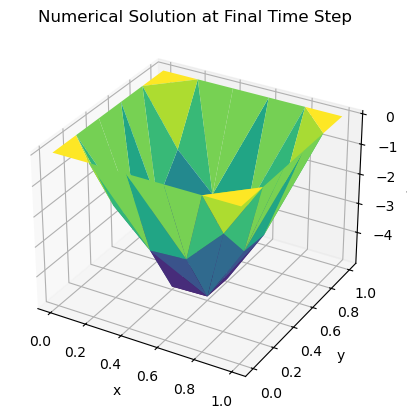

In [8]:
# Plot 1: Solution at Final Time Step
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# Extract the solution values
x = V.tabulate_dof_coordinates()[:, 0]
y = V.tabulate_dof_coordinates()[:, 1]
z = uh.x.array

# Create a 3D plot of the solution
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x, y, z, cmap=cm.viridis)

ax.set_title("Numerical Solution at Final Time Step")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x, y)")

plt.show()

ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

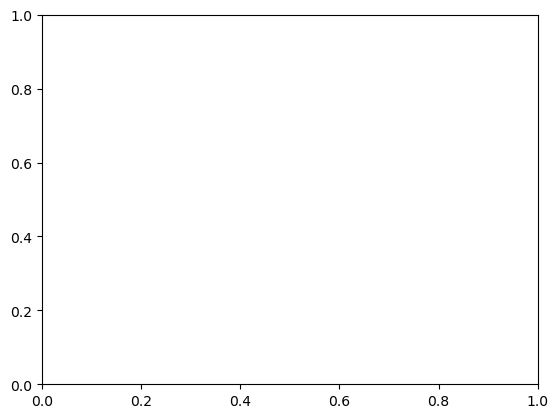

In [9]:
# Plot 2: Convergence Plot (L2 and H1 Errors)
time_steps = np.linspace(t0, t1, len(step_sizes))  # Time array based on step sizes
errors_L2 = [error_L2]  # Assuming error_L2 is computed at each step
errors_H1 = [E_H10]  # Assuming E_H10 is computed at each step

plt.figure()
plt.plot(time_steps, errors_L2, label='L2 Error')
plt.plot(time_steps, errors_H1, label='H1 Error')

plt.title("Convergence of Errors Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

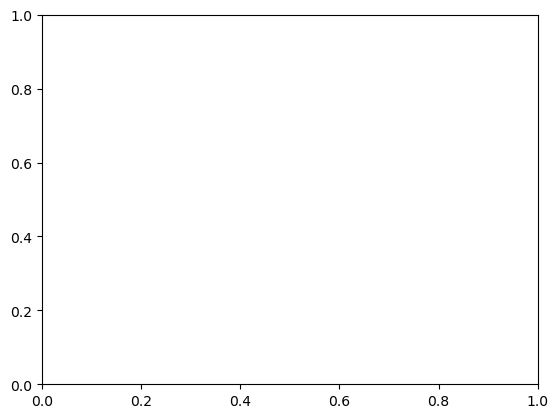

In [10]:
# Plot 3: Time-Stepping Sequence
plt.figure()
plt.plot(time_steps[:-1], step_sizes)

plt.title("Time-Stepping Sequence")
plt.xlabel("Time")
plt.ylabel("Step Size")
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

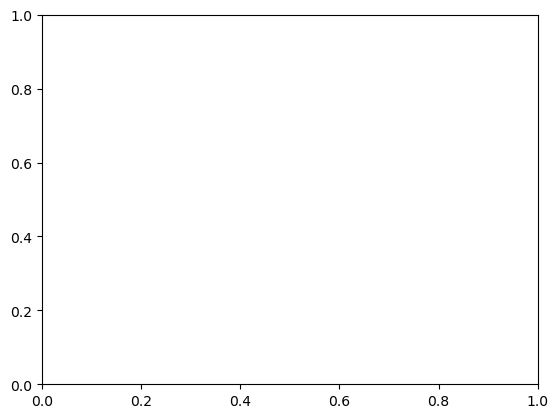

In [11]:
# Plot 4: Reward vs. Time Step
rewards = [...]  # Collect the reward values from the simulation loop

plt.figure()
plt.plot(time_steps[:-1], rewards)

plt.title("Reward vs. Time Step")
plt.xlabel("Time")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

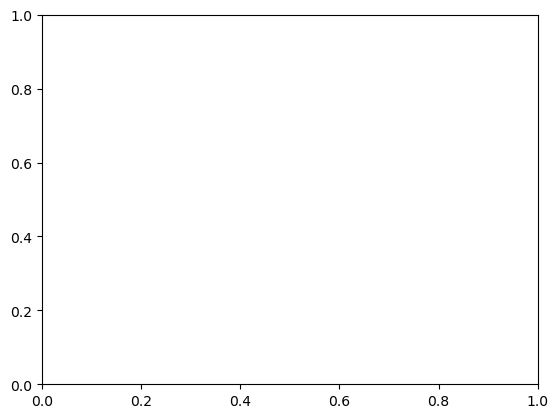

In [12]:
# Plot 5: Action Values vs. Time Step
action_values = [...]  # Collect the action values from the simulation loop

plt.figure()
plt.plot(time_steps[:-1], action_values)

plt.title("Action Values vs. Time Step")
plt.xlabel("Time")
plt.ylabel("Action Value")
plt.grid(True)
plt.show()

TypeError: float() argument must be a string or a real number, not 'ellipsis'

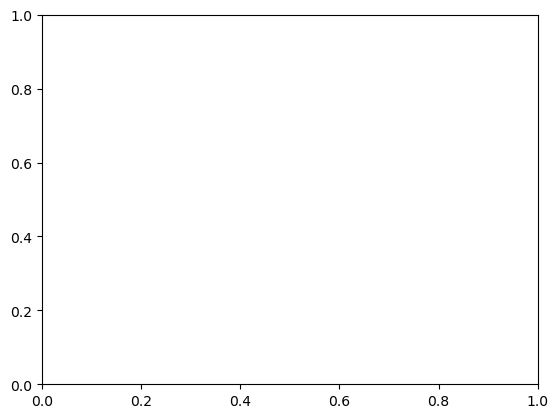

In [13]:
# Plot 6: Loss During Training
losses = [...]  # Collect the loss values from training

plt.figure()
plt.plot(np.arange(len(losses)), losses)

plt.title("Loss During Training")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [24]:
# Plot 7: Exact vs. Numerical Solution
z_exact = u_exact(np.vstack((x, y)))  # Compute exact solution on the mesh points

plt.figure()
plt.plot(x, z_exact, label='Exact Solution')
plt.plot(x, uh.x.array, label='Numerical Solution', linestyle='dashed')

plt.title("Exact vs. Numerical Solution")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.show()
